# **🎢DISNEYLAND REVIEW ANALYSIS with IBM GRANITE**

This project analyzes visitor reviews from Disneyland using artificial intelligence to understand what makes visitors happy or unhappy. I use IBM Granite AI model to automatically read and classify 42,000+ reviews, then create charts and reports to help Disneyland improve their services.

##**1. INSTALL AND IMPORT**

In [18]:
!pip install langchain_community
!pip install replicate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import kagglehub
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import replicate
import os
from tqdm import tqdm
import email
import time

##**2. SETUP AND CONFIGURATION**

In [25]:
def setup_replicate_api():
    try:
        from google.colab import userdata
        TOKEN = userdata.get('TOKEN_ENV')
    except ImportError:
        TOKEN = os.getenv('TOKEN_ENV')

    if not TOKEN:
        raise EnvironmentError("Token API Replicate tidak ditemukan. Pastikan secret 'TOKEN_ENV' telah disetel di os.environ['REPLICATE_API_TOKEN']")

    os.environ['REPLICATE_API_TOKEN'] = TOKEN
    MODEL_NAME = "ibm-granite/granite-3.3-8b-instruct"

    print("✅ Replicate API configured successfully")
    print(f"🤖 Using model: {MODEL_NAME}")

    return MODEL_NAME

##**3. LOADING AND PREPROCESSING DATA**

In [26]:
def load_raw_data(file_path='disneyland_reviews.csv', sample_size=1000):
    print("📥 Loading dataset Disneyland...")
    dataset_dir = kagglehub.dataset_download("arushchillar/disneyland-reviews")
    csv_path = os.path.join(dataset_dir, "DisneylandReviews.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File DisneylandReviews.csv tidak ditemukan: {csv_path}")
    df = pd.read_csv(csv_path, encoding='latin-1').sample(n=1000, random_state=42).reset_index(drop=True)
    print(f"✅ Data mentah dimuat: {len(df)} reviews")
    return df

def extract_review_details(df):
    print("🔍 Preprocessing review data...")

    df_clean = df.copy()
    df_clean['Review_Text'] = df_clean['Review_Text'].astype(str).str.strip()

    df_clean = df_clean[df_clean['Review_Text'] != ''].copy()
    df_clean = df_clean[df_clean['Review_Text'] != 'nan'].copy()

    print(f"✅ Data berhasil dipreprocessing: {len(df_clean)} reviews")
    return df_clean

##**4. IBM GRANITE CLASSIFICATION & SUMMARIZATION**

In [27]:
def classify_and_summarize(df, MODEL_NAME):
    print("🤖 Memulai klasifikasi sentiment dan ringkasan dengan IBM Granite via Replicate...")
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc='Analisis'):
        prompt = (
            f"You are an AI sentiment analyzer for Disneyland reviews. Analyze the following review and provide:\n\n"
            f"1. Classify the sentiment as exactly one of: Positive, Negative, or Neutral\n"
            f"2. Create a concise summary in 2-3 sentences\n\n"
            f"Respond in the following format strictly (no deviations):\n"
            f"Sentiment: <Positive/Negative/Neutral>\n"
            f"Summary: <concise summary in no more than 3 sentences covering only the key information>\n\n"
            f"Do not include any explanation, justification or extra notes.\n"
            f"Do not make up facts or summarize content not present in the review.\n\n"
            f"Review Details:\n"
            f"Location: {row.get('Reviewer_Location', 'Unknown')}\n"
            f"Rating: {row.get('Rating', 'N/A')}/5 stars\n"
            f"Branch: {row.get('Branch', 'Unknown')}\n"
            f"Review Text: {row.get('Review_Text', row.get('Body', ''))}"
        )
        try:
            output = replicate.run(
                MODEL_NAME,
                input={
                    "prompt": prompt,
                    "max_new_tokens": 1000,
                    "temperature": 0.2,
                    "top_p": 0.9,
                    "top_k": 40,
                    "repetition_penalty": 1.2
                }
            )
            text = "".join(output) if isinstance(output, (list, tuple)) else str(output)

            sentiment_match = re.search(r"Sentiment:\s*(Positive|Negative|Neutral)", text, re.IGNORECASE)
            summary_match = re.search(r"Summary:\s*(.+)", text, re.DOTALL)

            sentiment = sentiment_match.group(1).strip().capitalize() if sentiment_match else 'Neutral'
            summary = summary_match.group(1).strip() if summary_match else text.strip()

            if sentiment not in ['Positive', 'Negative', 'Neutral']:
                sentiment = 'Neutral'

        except Exception as e:
            print(f"❌ Error: {e}")
            sentiment = 'Neutral'
            summary = 'Error in processing'

            time.sleep(1)

        results.append({
            'Review_ID': row.get('Review_ID', ''),
            'Rating': row.get('Rating', ''),
            'Year_Month': row.get('Year_Month', row.get('Date', '')),
            'Reviewer_Location': row.get('Reviewer_Location', row.get('From', '')),
            'Review_Text': row.get('Review_Text', row.get('Body', '')),
            'Branch': row.get('Branch', ''),
            'Sentiment': sentiment,
            'Summary': summary
        })
    df_results = pd.DataFrame(results)
    df_results.to_csv('final_analysis_results.csv', index=False)
    print(f"✅ Berkas 'final_analysis_results.csv' disimpan dengan kolom Sentiment & Summary")
    return df_results

def map_to_sentiment(row, category, summary):
    positive_keywords = ['amazing', 'great', 'fantastic', 'wonderful', 'perfect', 'magical', 'loved', 'excellent', 'highly recommend']
    negative_keywords = ['terrible', 'worst', 'rude', 'dirty', 'expensive', 'crowded', 'poor', 'awful', 'horrible', 'disappointing']

    text_to_check = (summary + ' ' + str(row.get('Body', ''))).lower()

    positive_count = sum(1 for word in positive_keywords if word in text_to_check)
    negative_count = sum(1 for word in negative_keywords if word in text_to_check)

    rating = row.get('Subject', '')
    if 'Rating 5' in rating or 'Rating 4' in rating:
        positive_count += 2
    elif 'Rating 1' in rating or 'Rating 2' in rating:
        negative_count += 2

    if positive_count > negative_count:
        return 'Positive'
    elif negative_count > positive_count:
        return 'Negative'
    else:
        return 'Neutral'

##**5. EXPLORATORY DATA ANALYSIS (EDA)**

In [28]:
def perform_eda(df):
    print("📊 Melakukan Exploratory Data Analysis...")

    plt.style.use('default')
    sns.set_palette("husl")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sentiment_counts = df['Sentiment'].value_counts()
    colors = ['#4CAF50', '#F44336', '#FF9800']  # Green, Red, Orange for Pos, Neg, Neutral
    axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
                   colors=colors, startangle=90)
    axes[0, 0].set_title('Sentiment Review Disneyland', fontsize=14, fontweight='bold')

    if 'Branch' in df.columns and len(df['Branch'].unique()) > 1:
        sentiment_branch = pd.crosstab(df['Branch'], df['Sentiment'])
        sentiment_branch.plot(kind='bar', ax=axes[0, 1], color=colors)
        axes[0, 1].set_title('Sentiment per Branch', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Branch')
        axes[0, 1].set_ylabel('Jumlah Review')
        axes[0, 1].legend(title='Sentiment')
        axes[0, 1].tick_params(axis='x', rotation=45)
    else:
        if 'Reviewer_Location' in df.columns:
            location_sentiment = pd.crosstab(df['Reviewer_Location'], df['Sentiment']).head(10)
            location_sentiment.plot(kind='bar', ax=axes[0, 1], color=colors)
            axes[0, 1].set_title('Sentiment per Reviewer Location (Top 10)', fontsize=14, fontweight='bold')
            axes[0, 1].set_xlabel('Location')
            axes[0, 1].set_ylabel('Jumlah Review')
            axes[0, 1].legend(title='Sentiment')
            axes[0, 1].tick_params(axis='x', rotation=45)

    if 'Rating' in df.columns:
        df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
        df['Rating'].hist(bins=5, ax=axes[1, 0], color='skyblue', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Rating', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Rating (1-5 stars)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_xticks([1, 2, 3, 4, 5])

    if 'Rating' in df.columns:
        rating_sentiment = pd.crosstab(df['Rating'], df['Sentiment'])
        rating_sentiment.plot(kind='bar', ax=axes[1, 1], color=colors)
        axes[1, 1].set_title('Sentiment vs Rating', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Rating')
        axes[1, 1].set_ylabel('Jumlah Review')
        axes[1, 1].legend(title='Sentiment')
        axes[1, 1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

    print("\n📈 HASIL ANALISIS SENTIMENT DISNEYLAND:")
    print("="*45)
    print(f"Total Review Dianalisis: {len(df):,}")
    print("\nSentiment:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count/len(df))*100
        print(f"  {sentiment}: {count:,} ({percentage:.1f}%)")

    if 'Rating' in df.columns:
        avg_rating = df['Rating'].mean()
        print(f"\nRating rata-rata: {avg_rating:.1f}/5.0")

        print("\nSentiment per Rating:")
        rating_sentiment_pct = pd.crosstab(df['Rating'], df['Sentiment'], normalize='index') * 100
        for rating in sorted(df['Rating'].unique()):
            print(f"  Rating {rating}:")
            for sentiment in ['Positive', 'Negative', 'Neutral']:
                if sentiment in rating_sentiment_pct.columns:
                    pct = rating_sentiment_pct.loc[rating, sentiment]
                    print(f"    {sentiment}: {pct:.1f}%")

    print("\n🏰 ANALISIS PER BRANCH:")
    print("="*40)
    if 'Branch' in df.columns:
        branch_analysis = df.groupby('Branch')['Sentiment'].value_counts().unstack(fill_value=0)
        for branch in branch_analysis.index:
            print(f"\n{branch}:")
            total_branch = branch_analysis.loc[branch].sum()
            for sentiment in ['Positive', 'Negative', 'Neutral']:
                if sentiment in branch_analysis.columns:
                    count = branch_analysis.loc[branch, sentiment]
                    percentage = (count/total_branch)*100 if total_branch > 0 else 0
                    print(f"  {sentiment}: {count:,} ({percentage:.1f}%)")

    return df

def create_insights_and_findings(df):
    print("\n🔍 INSIGHT & FINDINGS - DISNEYLAND REVIEW ANALYSIS:")
    print("="*55)

    sentiment_stats = df['Sentiment'].value_counts()
    positive_pct = (sentiment_stats.get('Positive', 0) / len(df)) * 100
    negative_pct = (sentiment_stats.get('Negative', 0) / len(df)) * 100
    neutral_pct = (sentiment_stats.get('Neutral', 0) / len(df)) * 100

    print(f"📊 OVERALL SENTIMENT HEALTH:")
    print(f"   ✅ Positive Reviews: {positive_pct:.1f}%")
    print(f"   ❌ Negative Reviews: {negative_pct:.1f}%")
    print(f"   ⚪ Neutral Reviews: {neutral_pct:.1f}%")

    if positive_pct > 60:
        satisfaction_level = "TINGGI 🌟"
    elif positive_pct > 40:
        satisfaction_level = "SEDANG ⭐"
    else:
        satisfaction_level = "RENDAH ⚠️"

    print(f"   📈 Tingkat Kepuasan: {satisfaction_level}")

    if 'Rating' in df.columns:
        avg_rating = df['Rating'].mean()
        print(f"\n⭐ RATING ANALYSIS:")
        print(f"   Rata-rata Rating: {avg_rating:.1f}/5.0")

        rating_counts = df['Rating'].value_counts().sort_index()
        for rating, count in rating_counts.items():
            pct = (count / len(df)) * 100
            stars = "⭐" * int(rating)
            print(f"   {stars} ({rating}): {count} reviews ({pct:.1f}%)")

    if 'Branch' in df.columns and len(df['Branch'].unique()) > 1:
        branch_sentiment = df.groupby('Branch')['Sentiment'].apply(
            lambda x: (x == 'Positive').sum() / len(x) * 100
        ).round(1)

        best_branch = branch_sentiment.idxmax()
        worst_branch = branch_sentiment.idxmin()

        print(f"\n🏰 BRANCH PERFORMANCE:")
        print(f"   🏆 Best Branch: {best_branch} ({branch_sentiment[best_branch]:.1f}% positive)")
        print(f"   🔧 Needs Improvement: {worst_branch} ({branch_sentiment[worst_branch]:.1f}% positive)")

        print(f"\n   📊 All Branch Rankings:")
        for i, (branch, score) in enumerate(branch_sentiment.sort_values(ascending=False).items(), 1):
            emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "🏪"
            print(f"   {emoji} {i}. {branch}: {score:.1f}% positive")

    if 'Reviewer_Location' in df.columns:
        location_sentiment = df.groupby('Reviewer_Location')['Sentiment'].apply(
            lambda x: (x == 'Positive').sum() / len(x) * 100
        ).round(1)

        top_locations = location_sentiment.nlargest(5)
        print(f"\n🌍 TOP 5 MOST SATISFIED LOCATIONS:")
        for i, (location, score) in enumerate(top_locations.items(), 1):
            flag = "🇦🇺" if "Australia" in location else "🇵🇭" if "Philippines" in location else "🇦🇪" if "UAE" in location else "🇬🇧" if "Kingdom" in location else "🌏"
            print(f"   {flag} {i}. {location}: {score:.1f}% positive")

    if 'Summary' in df.columns:
        positive_summaries = ' '.join(df[df['Sentiment'] == 'Positive']['Summary'].astype(str))
        negative_summaries = ' '.join(df[df['Sentiment'] == 'Negative']['Summary'].astype(str))

        print(f"\n💬 KEY THEMES:")

        positive_words = re.findall(r'\b\w+\b', positive_summaries.lower())
        positive_common = Counter([word for word in positive_words if len(word) > 4])

        print(f"   ✅ Positive Themes:")
        for word, count in positive_common.most_common(5):
            print(f"      • {word.title()}: {count} mentions")

        negative_words = re.findall(r'\b\w+\b', negative_summaries.lower())
        negative_common = Counter([word for word in negative_words if len(word) > 4])

        print(f"   ❌ Negative Themes:")
        for word, count in negative_common.most_common(5):
            print(f"      • {word.title()}: {count} mentions")

    print(f"\n💡 BUSINESS RECOMMENDATIONS:")
    print("="*40)

    recommendations = []

    if negative_pct > 30:
        recommendations.append("🔸 Prioritas: Perbaiki pengalaman pengunjung untuk mengurangi review negatif")
    if positive_pct > 70:
        recommendations.append("🔸 Pertahankan: Standar layanan yang sudah baik ini harus dipertahankan")
    elif positive_pct < 50:
        recommendations.append("🔸 Urgent: Evaluasi menyeluruh operasional park diperlukan")

    if 'Branch' in df.columns and len(df['Branch'].unique()) > 1:
        recommendations.append(f"🔸 Benchmark: Terapkan best practice dari {best_branch} ke branch lain")
        recommendations.append(f"🔸 Focus: Berikan perhatian khusus pada {worst_branch}")

    recommendations.extend([
        "🔸 Monitor: Implementasi sistem monitoring feedback real-time",
        "🔸 Training: Program pelatihan staff berbasis customer feedback",
        "🔸 Analysis: Review mendalam setiap review negatif untuk improvement"
    ])
    for rec in recommendations:
        print(rec)

##**6. FINAL**

📊 Disneyland Review Analysis with IBM Granite
🚀 Memulai Disneyland Review Analysis dengan IBM Granite...
✅ Replicate API configured successfully
🤖 Using model: ibm-granite/granite-3.3-8b-instruct
📥 Loading dataset Disneyland...
✅ Data mentah dimuat: 1000 reviews
🔍 Preprocessing review data...
✅ Data berhasil dipreprocessing: 1000 reviews
🤖 Memulai klasifikasi sentiment dan ringkasan dengan IBM Granite via Replicate...


Analisis: 100%|██████████| 1000/1000 [12:55<00:00,  1.29it/s]


✅ Berkas 'final_analysis_results.csv' disimpan dengan kolom Sentiment & Summary
📊 Melakukan Exploratory Data Analysis...


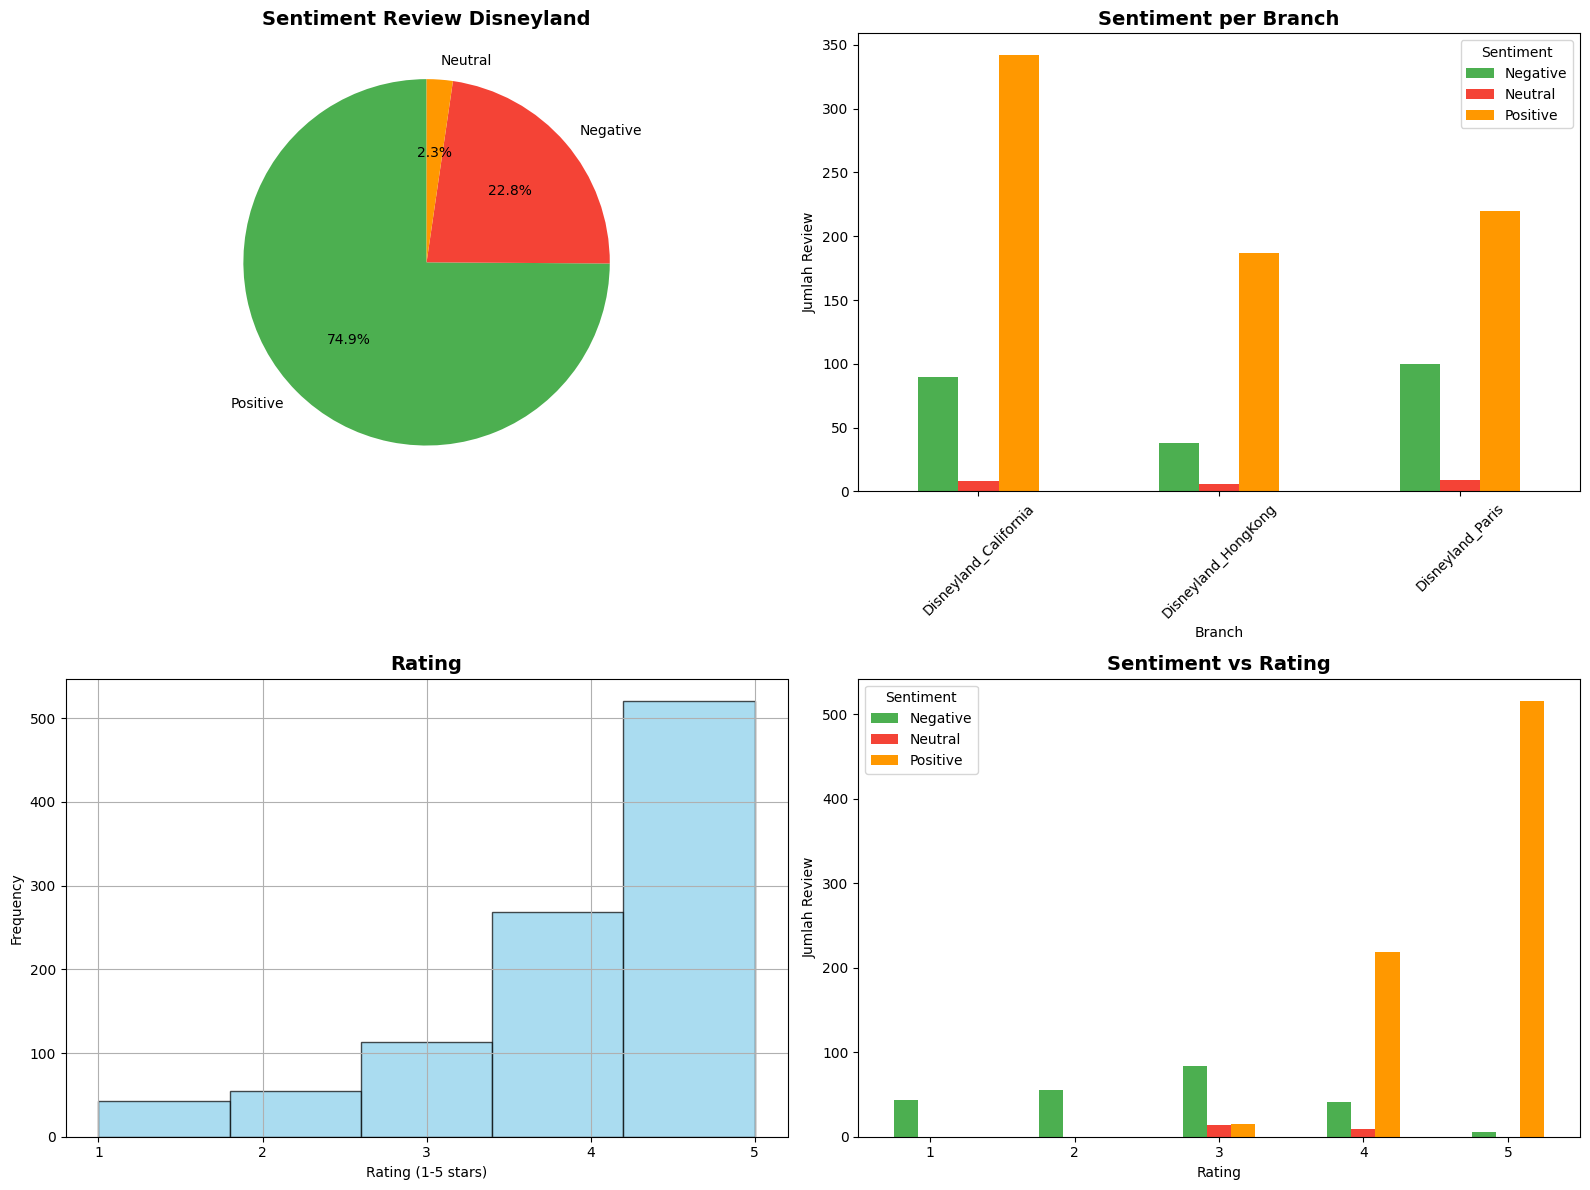


📈 HASIL ANALISIS SENTIMENT DISNEYLAND:
Total Review Dianalisis: 1,000

Sentiment:
  Positive: 749 (74.9%)
  Negative: 228 (22.8%)
  Neutral: 23 (2.3%)

Rating rata-rata: 4.2/5.0

Sentiment per Rating:
  Rating 1:
    Positive: 0.0%
    Negative: 100.0%
    Neutral: 0.0%
  Rating 2:
    Positive: 0.0%
    Negative: 100.0%
    Neutral: 0.0%
  Rating 3:
    Positive: 13.3%
    Negative: 74.3%
    Neutral: 12.4%
  Rating 4:
    Positive: 81.3%
    Negative: 15.3%
    Neutral: 3.4%
  Rating 5:
    Positive: 99.0%
    Negative: 1.0%
    Neutral: 0.0%

🏰 ANALISIS PER BRANCH:

Disneyland_California:
  Positive: 342 (77.7%)
  Negative: 90 (20.5%)
  Neutral: 8 (1.8%)

Disneyland_HongKong:
  Positive: 187 (81.0%)
  Negative: 38 (16.5%)
  Neutral: 6 (2.6%)

Disneyland_Paris:
  Positive: 220 (66.9%)
  Negative: 100 (30.4%)
  Neutral: 9 (2.7%)

🔍 INSIGHT & FINDINGS - DISNEYLAND REVIEW ANALYSIS:
📊 OVERALL SENTIMENT HEALTH:
   ✅ Positive Reviews: 74.9%
   ❌ Negative Reviews: 22.8%
   ⚪ Neutral Review

In [29]:
def main():
    print("📊 Disneyland Review Analysis with IBM Granite")
    print("="*50)
    print("🚀 Memulai Disneyland Review Analysis dengan IBM Granite...")
    try:
        MODEL_NAME = setup_replicate_api()
        raw_data = load_raw_data(sample_size=1000)
        extracted_data = extract_review_details(raw_data)
        final_df = classify_and_summarize(extracted_data, MODEL_NAME)
        final_df.to_csv('final_analysis_results.csv', index=False)
        final_df = perform_eda(final_df)
        create_insights_and_findings(final_df)

        print("\n✅ Proses selesai. Berikut 5 hasil pertama:")
        print(final_df.head().to_string(index=False))
        return final_df

    except Exception as e:
        print(f"❌ Error dalam eksekusi: {e}")
        return None

if __name__ == "__main__":
     main()